# Instalación

In [ ]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

# paquetes

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo

#Caso de Estudio: Empresa Vinícola Chilena "Vinos del Sur"

**Contexto:** La empresa "Vinos del Sur", una prestigiosa vinícola chilena, se enfrenta al desafío de optimizar su logística de exportación. Con viñedos en Maipo, Casablanca y Colchagua, la empresa necesita enviar sus vinos a clientes importantes en España y México. Debido a restricciones en las rutas navieras, los pedidos para cada uno de estos clientes deben ser enviados desde un solo puerto: Valparaíso para España y San Antonio para México.

**Objetivo de la Tarea:** Tu tarea es desarrollar un modelo de programación lineal para minimizar el costo total de transporte de los vinos de "Vinos del Sur", respetando las capacidades de producción de cada viñedo y satisfaciendo la demanda específica de los puertos.

# Datos del problema

In [ ]:
# oferta maxima
oferta = {
    'Maipo': 240,       #x1
    'Casablanca': 360,  #x2
    'Colchagua': 500    #x3
}
demanda = {
    'Valparaiso': 475,  # españa
    'SanAntonio': 510   # mexico
}
costos = {
    ('Maipo', 'Valparaiso'): 22000,
    ('Maipo', 'SanAntonio'): 26000,
    ('Casablanca', 'Valparaiso'): 18000,
    ('Casablanca', 'SanAntonio'): 23000,
    ('Colchagua', 'Valparaiso'): 30000,
    ('Colchagua', 'SanAntonio'): 28000
}

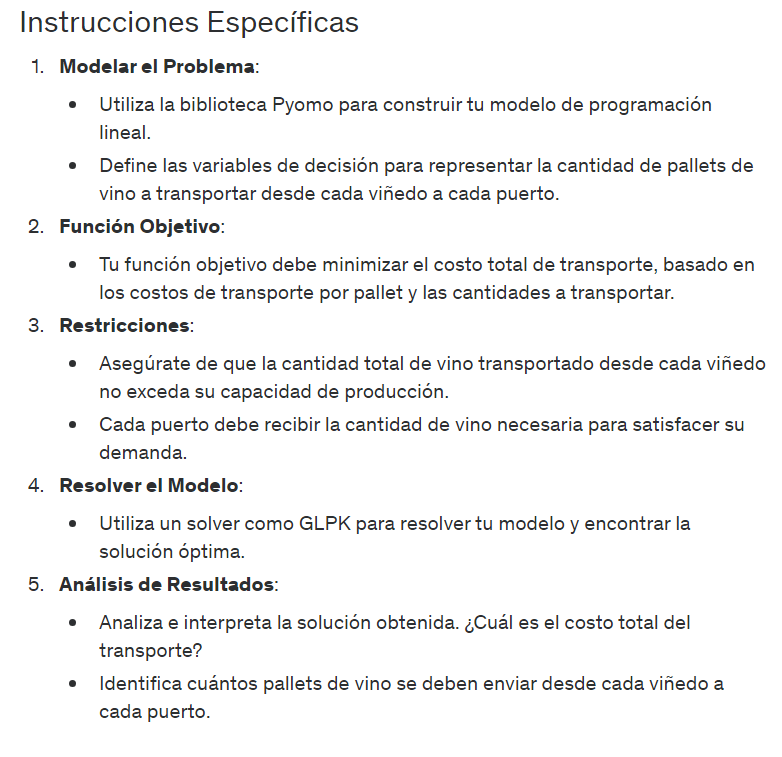

# instancia del modelo

In [ ]:
modelo = pyo.ConcreteModel()
modelo.dual = pyo.Suffix(direction = pyo.Suffix.IMPORT)

# Variables de decision

In [ ]:
vinedos = list(oferta.keys())
exportacion = list(demanda.keys())

In [ ]:
vinedos

['Maipo', 'Casablanca', 'Colchagua']

In [ ]:
exportacion

['Valparaiso', 'SanAntonio']

In [ ]:
# xij: (i) es el viñedo y (j) donde xij son los pallets de vino producidos por el viñedo (i) que se van a exportar desde el puerto (j)
modelo.x = pyo.Var(vinedos, exportacion, domain = pyo.NonNegativeIntegers)

# Restricción de producción máxima


In [ ]:
modelo.max_prod = pyo.ConstraintList()

for i in vinedos:
    modelo.max_prod.add(
       sum(modelo.x[i,j] for j in exportacion) <= oferta[i]
    )



# Restricción para satisfacer la demanda

In [ ]:
for j in exportacion:
    modelo.max_prod.add(
       sum(modelo.x[i,j] for i in vinedos) == demanda[j]
    )

# Función objetivo

In [ ]:
fo_costos =  []

for i in vinedos:
  for j in exportacion:
    fo_costos.append(
        modelo.x[i,j]*costos[i,j]
    )

modelo.objetivo = pyo.Objective(
    expr = sum(fo_costos),
    sense = pyo.minimize
)

# solución

In [ ]:
solucion = pyo.SolverFactory('glpk').solve(modelo)

In [ ]:
solucion.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 23040000.0
  Upper bound: 23040000.0
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 6
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.003551006317138672
# ----------------------------------------------------------
#   Solution Information
# -------------------------

# Solución: Variables de decisión

In [ ]:
resultados = {
    'vinedo':[],
    'puerto':[],
    'pallets':[]
}
print(f"Costo Total de exportación ${modelo.objetivo ():,.0f} pesos MX\n")
print("Con los siguientes envíos de pallets:")
for i in vinedos:
    for j in exportacion:
        if modelo.x[i,j]() >= 0:
            print(f"El viñedo {i} exporta desde el puerto {j}: {modelo.x[i,j]():,.0f} pallets de vino")

            resultados['vinedo'].append(i)
            resultados['puerto'].append(j)
            resultados['pallets'].append(modelo.x[i,j]())

resultados = pd.DataFrame(resultados )

Costo Total de exportación $23,040,000 pesos MX

Con los siguientes envíos de pallets:
El viñedo Maipo exporta desde el puerto Valparaiso: 115 pallets de vino
El viñedo Maipo exporta desde el puerto SanAntonio: 125 pallets de vino
El viñedo Casablanca exporta desde el puerto Valparaiso: 360 pallets de vino
El viñedo Casablanca exporta desde el puerto SanAntonio: 0 pallets de vino
El viñedo Colchagua exporta desde el puerto Valparaiso: 0 pallets de vino
El viñedo Colchagua exporta desde el puerto SanAntonio: 385 pallets de vino


In [ ]:
resultados = pd.pivot_table(
    resultados,
    index ='vinedo' ,
    columns = 'puerto',
    values = 'pallets'
)

In [ ]:
resultados

puerto,SanAntonio,Valparaiso
vinedo,,
Casablanca,0.0,360.0
Colchagua,385.0,0.0
Maipo,125.0,115.0


In [ ]:
resultados.sum(axis=0)

puerto
SanAntonio    510.0
Valparaiso    475.0
dtype: float64

In [ ]:
resultados.sum(axis=1)

vinedo
Casablanca    360.0
Colchagua     385.0
Maipo         240.0
dtype: float64